# Data Cleaning and Modeling for Colorado

## import necessary libraries

In [39]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix, classification_report, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold

## Import data for Colorado and clean

In [40]:
df = pd.read_csv('Data/covid_cases_per_county.csv')

In [41]:
CO = df[df.State == 'CO']

In [42]:
CO

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2021-03-21,2021-03-22,2021-03-23,2021-03-24,2021-03-25,2021-03-26,2021-03-27,2021-03-28,2021-03-29,2021-03-30
249,0,Statewide Unallocated,CO,8,0,0,0,0,0,0,...,55,55,55,55,57,57,57,57,57,57
250,8001,Adams County,CO,8,0,0,0,0,0,0,...,50463,50477,50596,50694,50812,50948,51051,51126,51185,51255
251,8003,Alamosa County,CO,8,0,0,0,0,0,0,...,1337,1338,1338,1338,1338,1339,1341,1343,1343,1343
252,8005,Arapahoe County,CO,8,0,0,0,0,0,0,...,50778,50814,50963,51090,51234,51352,51482,51603,51685,51762
253,8007,Archuleta County,CO,8,0,0,0,0,0,0,...,728,728,730,735,737,738,742,745,746,747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,8117,Summit County,CO,8,0,0,0,0,0,0,...,3216,3223,3247,3263,3278,3307,3335,3342,3359,3364
310,8119,Teller County,CO,8,0,0,0,0,0,0,...,1367,1368,1374,1378,1383,1400,1403,1405,1407,1418
311,8121,Washington County,CO,8,0,0,0,0,0,0,...,429,429,430,431,431,433,434,435,436,436
312,8123,Weld County,CO,8,0,0,0,0,0,0,...,26852,26864,26936,26995,27064,27141,27215,27274,27337,27385


In [43]:
CO = CO.drop(columns = ['countyFIPS','State','StateFIPS'])

In [44]:
CO = CO.drop([249])

In [45]:
#CO.set_index(['County'])

In [46]:
CO = CO.melt(id_vars=["County Name"], 
        var_name="date", 
        value_name="Cases")

In [47]:
CO = CO.rename(columns = {'County Name':'County_Name'})

In [48]:
CO.County_Name.value_counts()

Rio Blanco County     434
Jefferson County      434
Custer County         434
Ouray County          434
Arapahoe County       434
                     ... 
Cheyenne County       434
Eagle County          434
Gunnison County       434
Mineral County        434
Pueblo County         434
Name: County_Name, Length: 64, dtype: int64

In [49]:
x = lambda k: k.replace('City and County of Broomfield','Broomfield County').replace('City and County of Denver','Denver County')
CO.County_Name = [x(c[1]) for c in CO.County_Name.items()]

In [51]:
CO.date = pd.to_datetime(CO.date)

In [52]:
df2 = pd.read_csv('Data/covid_county_population.csv')

In [53]:
df2

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394
...,...,...,...,...
3190,56037,Sweetwater County,WY,42343
3191,56039,Teton County,WY,23464
3192,56041,Uinta County,WY,20226
3193,56043,Washakie County,WY,7805


In [54]:
COpop = df2[df2.State == 'CO']

In [55]:
COpop = COpop.drop([251])

In [56]:
COpop = COpop.drop(columns = ['State', 'countyFIPS'])

In [57]:
COpop = COpop.rename(columns = {'County Name':'County_Name'})

In [58]:
x = lambda k: k.replace('Broomfield County and City','Broomfield County')
COpop.County_Name = [x(c[1]) for c in COpop.County_Name.items()]

In [59]:
COpop.County_Name.value_counts()

Gunnison County       1
Washington County     1
Mineral County        1
Moffat County         1
Pitkin County         1
                     ..
Baca County           1
Sedgwick County       1
Clear Creek County    1
Ouray County          1
Boulder County        1
Name: County_Name, Length: 64, dtype: int64

In [62]:
df = pd.read_csv('Data/Restaurant_orders.csv')

In [63]:
## Function to clean restaurant orders data
def cleanerR(df):
    df['Effective_date'] = pd.to_datetime(df['Effective_date'])
    df.drop(columns = ['Effective_NA_Reason', 'Expiration_NA_Reason','Date_Signed','origin_dataset','Source_of_Action','URL','Citation','FIPS_State','FIPS_County','Action','Jurisdiction_Type','Issuing_Jurisdiction','order_code','Business_Type','Current_order_status','Effective_date','Expiration_date'], inplace = True)
    df.date = pd.to_datetime(df.date)
    df.sort_values(by = 'date', inplace = True)
    dfR = df[df.State_Tribe_Territory  == "CO"]
    dfR.drop(columns = ['State_Tribe_Territory'], inplace = True)
    dfR = dfR.rename(columns = {'order_group':'Rest_order'})
    return dfR

In [64]:
dfRCO = cleanerR(df) 

In [65]:
dfRCO

,County_Name,date,Rest_order
72124,Archuleta County,2020-03-15,No restriction found
71832,Arapahoe County,2020-03-15,No restriction found
71540,Alamosa County,2020-03-15,No restriction found
71248,Adams County,2020-03-15,No restriction found
72416,Baca County,2020-03-15,No restriction found
...,...,...,...
72707,Baca County,2020-12-31,Open with limitations
72415,Archuleta County,2020-12-31,Open with limitations
72123,Arapahoe County,2020-12-31,Open with limitations
71831,Alamosa County,2020-12-31,Open with limitations


In [66]:
df2 = pd.read_csv('Data/Mask_Mandates2.csv')

In [67]:
## Function to clean Mask Mandates data
def cleanerM(df2):
    df2.drop(columns = ['Jurisdiction_Type','Issuing_Jurisdiction','Date_Signed','origin_dataset','Source_of_Action','URL','Citation'], inplace = True)
    dfM = df2[df2.State_Tribe_Territory  == "CO"]
    dfM.drop(columns = ['FIPS_State', 'Effective_NA_Reason','Expiration_NA_Reason', 'FIPS_County','State_Tribe_Territory','Effective_date','Expiration_date'], inplace = True)
    dfM.date = pd.to_datetime(dfM.date)
    dfM = dfM.rename(columns = {'Current_order_status': 'Mask_order'})
    dfM.sort_values(by = 'date', inplace = True)
    dfM.fillna('NA', inplace = True)
    return dfM

In [68]:
dfMCO = cleanerM(df2)

In [69]:
dfMCO

,County_Name,date,Mask_order,Face_Masks_Required_in_Public
72468,Adams County,2020-04-10,No Public Mask Mandate,NA
79596,Gilpin County,2020-04-10,No Public Mask Mandate,NA
79893,Grand County,2020-04-10,No Public Mask Mandate,NA
89397,San Miguel County,2020-04-10,No Public Mask Mandate,NA
80487,Hinsdale County,2020-04-10,No Public Mask Mandate,NA
...,...,...,...,...
83159,Larimer County,2021-01-31,Public Mask Mandate,Yes
82862,La Plata County,2021-01-31,Public Mask Mandate,Yes
82565,Lake County,2021-01-31,Public Mask Mandate,Yes
86426,Ouray County,2021-01-31,Public Mask Mandate,Yes


In [70]:
df3 = pd.read_csv('Data/Gathering_Bans.csv')

In [71]:
## Function to clean gathering bans data
def cleanerG(df3):
    df3.drop(columns = ['origin_dataset','Source_of_Action','URL','Citation','General_GB_order_code','With_SD_order_code','Outdoor_Household_Order_Code'], inplace = True)
    dfG = df3[df3.State_Tribe_Territory  == "CO"]
    dfG.drop(columns = ['FIPS_State','FIPS_County','Effective_NA_Reason','Expiration_NA_Reason','General_Household_order_code','Express_Preemption','Bans_Households_Not_Individuals_Outdoor_Only','Outdoor_Household_Order_Group','Bans_Households_Not_Individuals_Generally','outdoor_order_group','outdoor_order_code','General_Or_Under_6ft_Bans_Outdoor_Gatherings_Over','Issuing_Jurisdiction','Jurisdiction_Type','With_SD_outdoor_order_code','General_Household_Order_Group','State_Tribe_Territory','Date_Signed','Over_6ft_Bans_Outdoor_Gatherings_Over', 'Indoor_Outdoor','Effective_date','Expiration_date','Over_6ft_Bans_Gatherings_Over','General_or_Under_6ft_Bans_Gatherings_Over','With_SD_outdoor_order_group','Current_order_status'], inplace = True)
    dfG.date = pd.to_datetime(dfG.date)
    dfG.sort_values(by = 'date', inplace = True)
    dfG.fillna('NA', inplace = True)
    return dfG

In [72]:
dfGCO = cleanerG(df3)

C:\Users\mered\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
##dfGCO.set_index(["County_Name"])

,date,General_GB_order_group,With_SD_order_group
County_Name,,,
Adams County,2020-03-11,No order found,No order found
Gilpin County,2020-03-11,No order found,No order found
Garfield County,2020-03-11,No order found,No order found
Fremont County,2020-03-11,No order found,No order found
Sedgwick County,2020-03-11,No order found,No order found
...,...,...,...
Larimer County,2020-12-31,Bans gatherings of any size,No order found
La Plata County,2020-12-31,Bans gatherings of any size,No order found
Lake County,2020-12-31,Ban of gatherings over 1-10 people,No order found


In [204]:
## Function to merge all dataframes

def merge(df1, df2, df3, df4, df7):
    df4_copy = df4.copy()
    df7_copy = df7.copy()
    df = df1.merge(df2, how = 'outer',  on =['date','County_Name'])
    df5 = df.merge(df3, how = 'outer', on =['date','County_Name'])
 
    df4_copy.County_Name = [d[1].strip() for d in df4.County_Name.items()]
    df5.County_Name = [d[1].strip() for d in df5.County_Name.items()]
    df7.County_Name = [d[1].strip() for d in df7.County_Name.items()]
    df4_copy.County_Name = df4_copy.County_Name.astype(str)
    df5.County_Name = df5.County_Name.astype(str)
    df4_copy.sort_values(by='County_Name',inplace=True)
    df6 = df5.merge(df4_copy, on=['County_Name','date'], how="outer")
    df8 = df6.merge(df7, on=['County_Name'], how="left")
    df8.sort_values(by='County_Name', inplace=True)
   
    start_date = '2020-03-11'
    end_date = '2021-01-31'
    after_start_date = df8["date"] >= start_date

    before_end_date = df8["date"] <= end_date

    between_two_dates = after_start_date & before_end_date

    final = df8.loc[between_two_dates]
    
    final.sort_values(by = ['date','County_Name'], inplace = True)
    final['Cases/Population'] = final.apply(lambda row: row.Cases/row.population, axis = 1)
    final['Cases/Population'].fillna(0, inplace = True)
    final.fillna('NA', inplace = True)
    R = {'NA':0,'No restriction found':1,'Curbside/delivery only':2,'Open with limitations':3 }
    final.Rest_order.replace(R, inplace=True)
    M = {'NA':0,'No Public Mask Mandate' :1,'Public Mask Mandate':2}
    final.Mask_order.replace(M, inplace=True)
    F = {'NA':0,'Yes' :1}
    final.Face_Masks_Required_in_Public.replace(F, inplace=True)
    S = {'NA':0,'Ban of gatherings over 51-100 people' :1,'No order found':2}
    final.With_SD_order_group.replace(S, inplace=True)
    G = {'NA':0,'No order found':1,'Ban of gatherings over 11-25 people':2,'Ban of gatherings over 1-10 people':3,'Bans gatherings of any size':4}
    final.General_GB_order_group.replace(G, inplace=True)
    return final

finaldfCO = merge(dfRCO, dfMCO, dfGCO, CO, COpop)
finaldfCO



C:\Users\mered\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mered\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mered\anaconda3\envs\learn-env\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,County_Name,date,Rest_order,Mask_order,Face_Masks_Required_in_Public,General_GB_order_group,With_SD_order_group,Cases,population,Cases/Population
20672,Adams County,2020-03-11,0,0,0,1,2,0,517421,0.000000
20734,Alamosa County,2020-03-11,0,0,0,1,2,0,16233,0.000000
20702,Arapahoe County,2020-03-11,0,0,0,1,2,3,656590,0.000005
20700,Archuleta County,2020-03-11,0,0,0,1,2,0,14029,0.000000
20698,Baca County,2020-03-11,0,0,0,1,2,0,3581,0.000000
...,...,...,...,...,...,...,...,...,...,...
20643,Summit County,2021-01-31,0,2,1,0,0,2646,31011,0.085325
20642,Teller County,2021-01-31,0,2,1,0,0,1181,25388,0.046518
20609,Washington County,2021-01-31,0,2,1,0,0,363,4908,0.073961
20639,Weld County,2021-01-31,0,2,1,0,0,23586,324492,0.072686


In [206]:
finaldfCO.to_csv('Data/Colorado_data.csv', index = False)

# Begin Modeling Process

In [77]:
## Create X and Y Variables

y = finaldfCO['Cases/Population']
X = finaldfCO.drop(columns = ['Cases/Population', 'County_Name','date','population','Cases'], axis = 1)

In [78]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

In [79]:
## Fit baseline model
reg_1 = DecisionTreeRegressor()

In [104]:
## Model Evaluator Function
def evaluator(X_train, y_train, X_test, y_test, model):   
    start = time.time()
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    end = time.time()
    print("Model Time: {}".format(end-start))
    print('R Squared Score is:', r2_score(y_test, test_preds))
    print('Training:')
    print('Mean Absolute Error:', mean_absolute_error(y_train, train_preds))  
    print('Mean Squared Error:', mean_squared_error(y_train, train_preds))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, train_preds)))
    print('Testing:')
    print('Mean Absolute Error:', mean_absolute_error(y_test, test_preds))  
    print('Mean Squared Error:', mean_squared_error(y_test, test_preds))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_preds)))

In [97]:
evaluator(x_train, y_train, x_test, y_test, reg_1)

Model Time: 0.008007287979125977
R Squared Score is: 0.5456325841101033
Training:
Mean Absolute Error: 0.008097852439114936
Mean Squared Error: 0.00033731578353755556
Root Mean Squared Error: 0.018366158649471467
Testing:
Mean Absolute Error: 0.00808854163146654
Mean Squared Error: 0.00034908170209275893
Root Mean Squared Error: 0.018683728270684066


In [133]:
## gridsearch for best decision tree model
parameters={"splitter":["best","random"],
            "max_depth" : [1,7,9,12],
           "min_samples_leaf":[1,5,10],
           
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,50,90] }

In [140]:
DT_grid=GridSearchCV(estimator=reg_1,param_grid=parameters, scoring = 'r2', n_jobs=1)

In [141]:
evaluator(x_train, y_train, x_test, y_test, DT_grid)

Model Time: 9.119949340820312
R Squared Score is: 0.5456325842623004
Training:
Mean Absolute Error: 0.008097852068171435
Mean Squared Error: 0.0003373157835394294
Root Mean Squared Error: 0.018366158649522478
Testing:
Mean Absolute Error: 0.008088541521557354
Mean Squared Error: 0.00034908170197582876
Root Mean Squared Error: 0.018683728267554867


In [142]:
DT_grid.best_params_

{'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'splitter': 'best'}

In [158]:
DT_grid.best_score_

0.5596832599155215

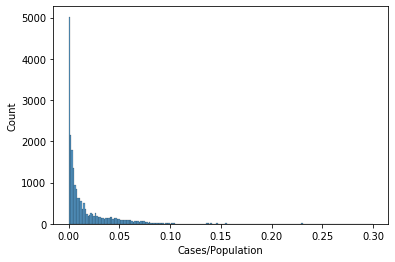

In [174]:
## To understand the error in context, the distribution of Cases/Population
ax = sns.histplot(x = finaldf['Cases/Population'])

In [87]:
## We can also see that the mean value is very low, giving context to the error numbers
finaldf['Cases/Population'].mean()

0.01687998087298965

In [172]:
## Std is higher than the error rates, model is predicting within one standard deviation
finaldf['Cases/Population'].std()

0.02766291069996377

In [154]:
## Trying Enslemble regressor model with gridsearch
GBR=GradientBoostingRegressor()


search_grid={'n_estimators':[5000,10000],'learning_rate':[.25,.4,.5],'max_depth':[4,7,10],'subsample':[.1,.25,.5],'random_state':[2,3]}

GBR_grid=GridSearchCV(estimator=GBR,param_grid=search_grid, scoring = 'r2')

In [155]:
evaluator(x_train, y_train, x_test, y_test, GBR_grid)

Model Time: 6129.468991518021
R Squared Score is: 0.5457283991504578
Training:
Mean Absolute Error: 0.008021597108860136
Mean Squared Error: 0.000337594217141175
Root Mean Squared Error: 0.01837373715772529
Testing:
Mean Absolute Error: 0.008010734292964406
Mean Squared Error: 0.0003490080892494886
Root Mean Squared Error: 0.018681758194813693


In [156]:
GBR_grid.best_params_

{'learning_rate': 0.5,
 'max_depth': 7,
 'n_estimators': 10000,
 'random_state': 3,
 'subsample': 0.25}

In [157]:
GBR_grid.best_score_

0.5607422102534763

In [210]:
GBR=GradientBoostingRegressor()


search_grid={'n_estimators':[100,200,500],'learning_rate':[.25,.4,.5],'max_depth':[4,7,10],'subsample':[.1,.25,.5],'random_state':[2,3]}

GBR_grid=GridSearchCV(estimator=GBR,param_grid=search_grid, scoring = 'neg_mean_squared_error')

evaluator(x_train, y_train, x_test, y_test, GBR_grid)

Model Time: 319.658828496933
R Squared Score is: 0.5458234137118863
Training:
Mean Absolute Error: 0.008038312980031954
Mean Squared Error: 0.0003375124930932349
Root Mean Squared Error: 0.018371513086657694
Testing:
Mean Absolute Error: 0.008024926274175495
Mean Squared Error: 0.0003489350913987028
Root Mean Squared Error: 0.01867980437260259


In [211]:
GBR_grid.best_score_

-0.00033790400317348885

In [212]:
GBR_grid.best_params_

{'learning_rate': 0.5,
 'max_depth': 4,
 'n_estimators': 100,
 'random_state': 2,
 'subsample': 0.25}

In [178]:
## Final Best Model
GBR_best = GradientBoostingRegressor(learning_rate = 0.5,
 max_depth = 4,
 n_estimators = 100,
 random_state= 2,
 subsample= 0.25)

evaluator(x_train, y_train, x_test, y_test, GBR_best)

Model Time: 0.19932293891906738
R Squared Score is: 0.5458234137118863
Training:
Mean Absolute Error: 0.008038312980031954
Mean Squared Error: 0.0003375124930932349
Root Mean Squared Error: 0.018371513086657694
Testing:
Mean Absolute Error: 0.008024926274175495
Mean Squared Error: 0.0003489350913987028
Root Mean Squared Error: 0.01867980437260259


In [ ]:
## Function to view feature importance
def plot_feature_importances(model):
    n_features = x_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_) 
    plt.yticks(np.arange(n_features), x_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

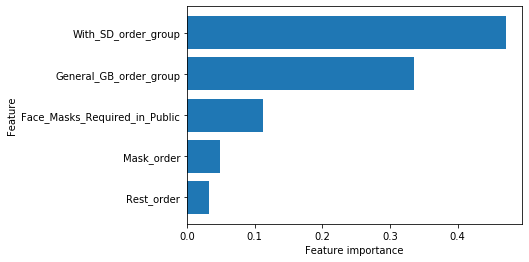

In [179]:
## The model used the order group -- with social distancing gathering mandates 
## Restaurant mandates were the least important for the model
plot_feature_importances(GBR_best)

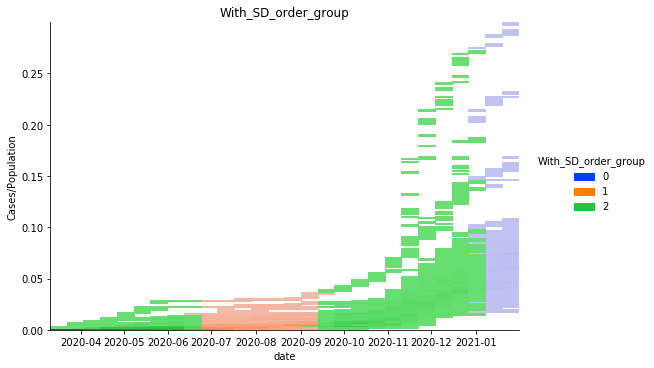

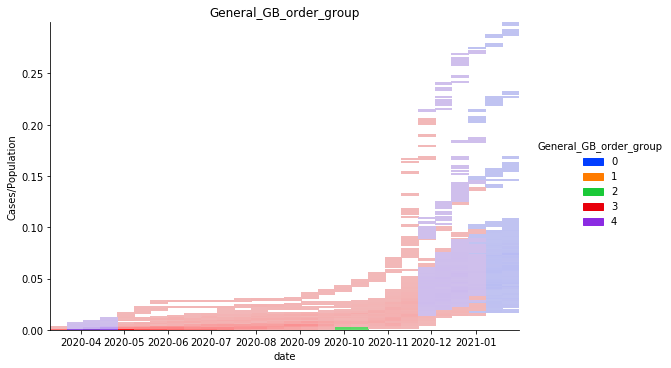

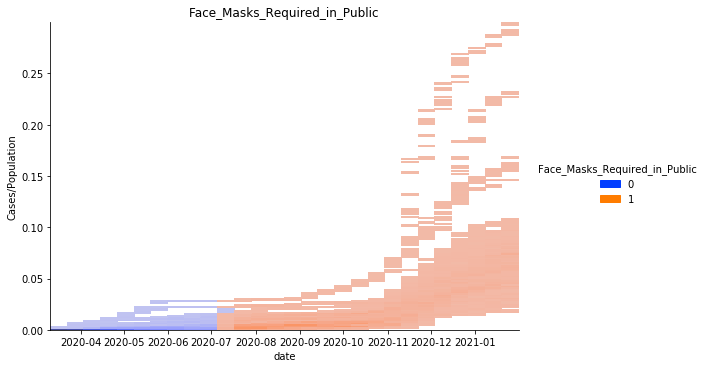

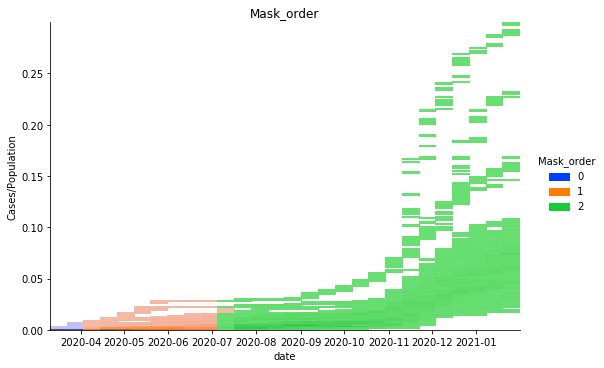

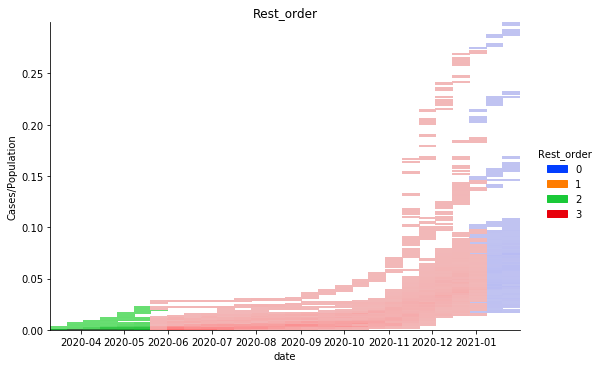

In [220]:
hues = ["With_SD_order_group","General_GB_order_group","Face_Masks_Required_in_Public","Mask_order","Rest_order"]


for hue in hues:
    sns.displot(data = finaldfCO, x = "date", y = "Cases/Population", hue = hue, palette = "bright", aspect = 1.5)
    plt.title(f"{hue}")